# Playground: Stellar Disk Morphology

In [6]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as c
# import previous HW functions
from RL_ReadFile import Read
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# Plotly's Python graphing library makes interactive, publication-quality graphs


In [7]:
# nbagg is the matplotlib backend for interactive plotting in notebooks
%matplotlib nbagg

## Previous HW classes/functions

### Modified CenterOfMass with VolDec (from HW 6)

In [8]:
class CenterOfMass:
    """ Hold the COM position & velocity of a galaxy at a given snapshot """
    
    def __init__(self, filename, ptype):
        """ Initialize this class with relevant data """
        
        # read in the file
        self.time, self.total, self.data = Read(filename)
        
        # extract particles with the desired type
        self.par_data = self.data[self.data['type'] == ptype]
        
        # extract the mass, positions, and velocities of particles of interest
        self.m = self.par_data['m']
        self.r = self.par_data['r']
        self.v = self.par_data['v']
        
    def COMdefine(self, q, m):
        """ Return the mass-weighted mean position(q) in a given phase space """
        
        # because q has the shape of (total, 3) and m has the shape of (total,)
        # we need to give m a virtual axis to broadcast array operations;
        # then we sum along axis 0 (i.e., sum up all particles)
        # this function will then return a 3-element array
        return np.sum(q * m[:, np.newaxis], axis=0) / np.sum(m)
        
    def COM_P(self, delta, VolDec):
        """ Iteratively determine the COM position """
        
        # get the first COM guess by calling COMdefine on all particles
        COM_r = self.COMdefine(self.r, self.m)
        # calculate the magnitude of the COM position vector
        COM_r_mag = np.sqrt(np.sum(COM_r**2))
        
        # calculate the coordinates of particles in the new COM reference frame
        par_r = self.r - COM_r
        par_r_mag = np.sqrt(np.sum(par_r**2, axis=1))
        par_m = self.m
        
        # use a reduced distance of the farthest particle for new calculations
        par_r_max = max(par_r_mag) / VolDec
        # create a guess list of the COM position vectors
        COM_r_list = []; COM_r_list.append(COM_r)
        # choose an initial estiamte for the change in COM position
        change = 1000.0
        
        # now iterative the following process to determine the COM
        while change > delta:
            
            # extract the particles within the reduced volume
            par_r = par_r[par_r_mag < par_r_max]
            par_m = par_m[par_r_mag < par_r_max]
            
            # get the new COM guess based on remaining particles and append it
            COM_r = self.COMdefine(par_r, par_m)
            COM_r_mag = np.sqrt(np.sum(COM_r**2))
            COM_r_list.append(COM_r)
            
            # COM_r_mag is exactly the change in COM position
            # between the previous guess and this guess
            change = COM_r_mag
            #print(COM_r, change) # if interested, print them out
            
            # prepare for the next round of calculations
            par_r_max /= VolDec # shrink the volume radius again
            par_r = par_r - COM_r # shift particles to the new reference frame
            par_r_mag = np.sqrt(np.sum(par_r**2, axis=1)) # get new magnitudes
        
        # Note: each COM guess is in the reference frame of the previous guess
        COM_r_list = np.asarray(COM_r_list) # convert array list to a 2d array
        # convert each guess back to the original coordinate system
        COM_r_list = np.cumsum(COM_r_list, axis=0)
        
        # return the final guess of COM position vector (round it and add units)
        return np.round(COM_r_list[-1], 2) * u.kpc
    
    def COM_V(self, COM_r):
        """ Return the COM velocity based on the COM position """
        
        # the max distance from the COM_r 
        # that we will use to determine the COM velocity
        RV_MAX = 15.0 * u.kpc
        
        # calculate the coordinates of particles in the new COM reference frame
        # since COM_r has units, further calculations need to be dimensional
        par_r = self.r * u.kpc - COM_r
        par_r_mag = np.sqrt(np.sum(par_r**2, axis=1))
        
        # extract the particle properties within the max distance
        par_v = self.v[par_r_mag < RV_MAX]
        par_m = self.m[par_r_mag < RV_MAX]
        
        # calculate the COM velocity
        COM_v = self.COMdefine(par_v, par_m)
        
        # return the COM velocity (round it and add units)
        return np.round(COM_v, 2) * u.km/u.s        

### Rotate Frame to align with the Angular Momentum (from Lab 7)

In [9]:
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 
# reference: https://math.stackexchange.com/a/476311/738155

def RotateFrame(posI, velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI, velI), axis=0)
    # normalize the vector
    L_norm = L / np.sqrt(np.sum(L**2))

    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
   
    # z unit vector and Identity matrix
    z_norm = np.array([0, 0, 1])
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # two special cases need attentions
    if c == 1: # when L_norm points the same direction as z_norm
        R = I
    elif c == -1: # when L_norm and z_norm point into exactly opposite directions
        # a rotation of pi about any axis perpendicular to z_norm works
        R = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]) # here it is about x-axis
    else:    
        # rotation matrix
        v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
        R = I + v_x + np.dot(v_x, v_x) * (1 - c) / s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

## Surface Density Radial Profile

#### In this notebook, we are interested in the surface density radial profile of a galaxy's stellar disk, $\Sigma(r)$. Because we have all the particle data, we can first `RotateFrame` to align the disk particles with their total angular momentum and then modify the `MassProfile` code from HW 5 to divide disk into many annuli and compute the surface density in each annuli (total mass divided by the area of the annuli). 

A similar technique is widely used in protoplanetary disk (PPD) observations to obtain the radial intensity profile (the terms used are a bit different in that field: `deprojection` and `azimuthal averaging`).

In [10]:
class SurfaceDensityProfile:
    """ calculate the surface density profile of a galaxy at a snapshot """
    
    def __init__(self, data_dir, galaxy, snap_id, radii=None):
        """ initialization
        input:
            galaxy: the name of the galaxy of interest
            snap_id: the number of the snapshot of interest
            radii: an array of radii from a near-center point to the outer skirt
                   default value: np.arange(0.1, 0.95*r_outermost, 1.0)
                   feel free to choose a finer step length for high resolution data
        """
    
        # compose the data filename to read
        self.filename = data_dir + galaxy + "_{:03d}".format(snap_id) + ".txt"
        
        # set tolerance and VolDec for calculating COM_P in CenterOfMass
        delta, VolDec = 0.1, 2.0
        if galaxy is "M33": # for M33 that is stripped more, use different values
            delta, VolDec = 0.1, 4.0
        
        # calculate the COM position and velocity
        # N.B.: self.com contains lots of info, see its member variables in the definition above
        self.com = CenterOfMass(self.filename, 2)
        com_r = self.com.COM_P(delta, VolDec)
        com_v = self.com.COM_V(com_r)
        self.com_r, self.com_v = com_r.value, com_v.value # remove the units for convenience

        # rotate the frame to align the disk with angular momentum
        # note that self.com.r is the position vectors of all disk particles in the original frame
        #       and self.com.v is the velocity vectors of all disk particles in the original frame
        self.alg_r, self.alg_v = RotateFrame(self.com.r - self.com_r, self.com.v - self.com_v)

        # calculate the radial distances and azimuthal angles in the cylindrical coordinates
        self.cyl_r_mag = np.sqrt(np.sum(self.alg_r[:, :2]**2, axis=1))
        self.cyl_theta = np.arctan2(self.alg_r[:, 1], self.alg_r[:, 0])

        # check if radii is already set
        if radii is None:
            self.radii = np.arange(0.1, 0.95 * self.cyl_r_mag.max(), 1.0)
        else:
            self.radii = radii
            # can be improved by checking how many elements "radii" has

        # create the mask to select particles for each radius
        # np.newaxis creates a virtual axis to make tmp_r_mag 2 dimensional
        # so that all radii can be compared simultaneously
        enc_mask = self.cyl_r_mag[:, np.newaxis] < np.asarray(self.radii).flatten()
        # calculate the enclosed masses within each radius
        # relevant particles will be selected by enc_mask (i.e., *1)
        # outer particles will be ignored (i.e., *0)
        self.m_enc = np.sum(self.com.m[:, np.newaxis] * enc_mask, axis=0)

        # use the difference between nearby elements to get mass in each annulus
        # N.B.: we ignored the very central tiny circle and a small portion of outermost particles
        #       feel free to modify it to fit your needs
        self.m_annuli = np.diff(self.m_enc) # this array is one element less then m_enc
        
        # calculate the surface density by dividing the area of the annulus
        self.Sigma = self.m_annuli / (np.pi * (self.radii[1:]**2 - self.radii[:-1]**2))
        
        # we use the geometric mean of two consecutive elements in "radii" as the radius of each annulus
        # this array have the same amount of elements as self.Sigma, can be used for plotting
        self.r_annuli = np.sqrt(self.radii[1:] * self.radii[:-1])

In [19]:
sdp0 = SurfaceDensityProfile("HighRes_sample/","M33", 0, radii = np.arange(0.01,5,0.1))
sdp1 = SurfaceDensityProfile("HighRes_sample/","M33", 300,radii = np.arange(0.01,5,0.1))
sdp2 = SurfaceDensityProfile("HighRes_sample/","M33", 580,radii = np.arange(0.01,5,0.1))
sdp3 = SurfaceDensityProfile("HighRes_sample/","M33", 800,radii = np.arange(0.01,5,0.1))

In [1]:
# plot the surface density profiles of the MW stellar disk
fig, ax = plt.subplots(figsize=(9, 8))
ax.semilogy(sdp0.r_annuli, sdp0.Sigma, label="$t={:.1f}$ Gyr".format(sdp0.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp1.r_annuli, sdp1.Sigma, label="$t={:.1f}$ Gyr".format(sdp1.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp2.r_annuli, sdp2.Sigma, label="$t={:.1f}$ Gyr".format(sdp2.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp3.r_annuli, sdp3.Sigma, label="$t={:.1f}$ Gyr".format(sdp3.com.time.value/1e3), lw=2, alpha=0.75)
ax.set(xlabel=r"$r$ [kpc]", ylabel=r"$\Sigma$(disk) [$10^{10} M_\odot$ / kpc$^2$]", title="MW Stellar Disk", 
       xlim=( 0.1,5), ylim=(1e-5, 1))
ax.legend(loc='best'); fig.tight_layout()

NameError: name 'plt' is not defined

## Disk Internal Structures

#### In this notebook, we are also interested in understanding the disk internal structures (you can extend the content here to understand their evolution). Different visualizations may help us form a better idea of what is going on.  For example, we explore different ways, in the next few cells, to visualize the spirals of the MW stellar disks.

<IPython.core.display.Javascript object>


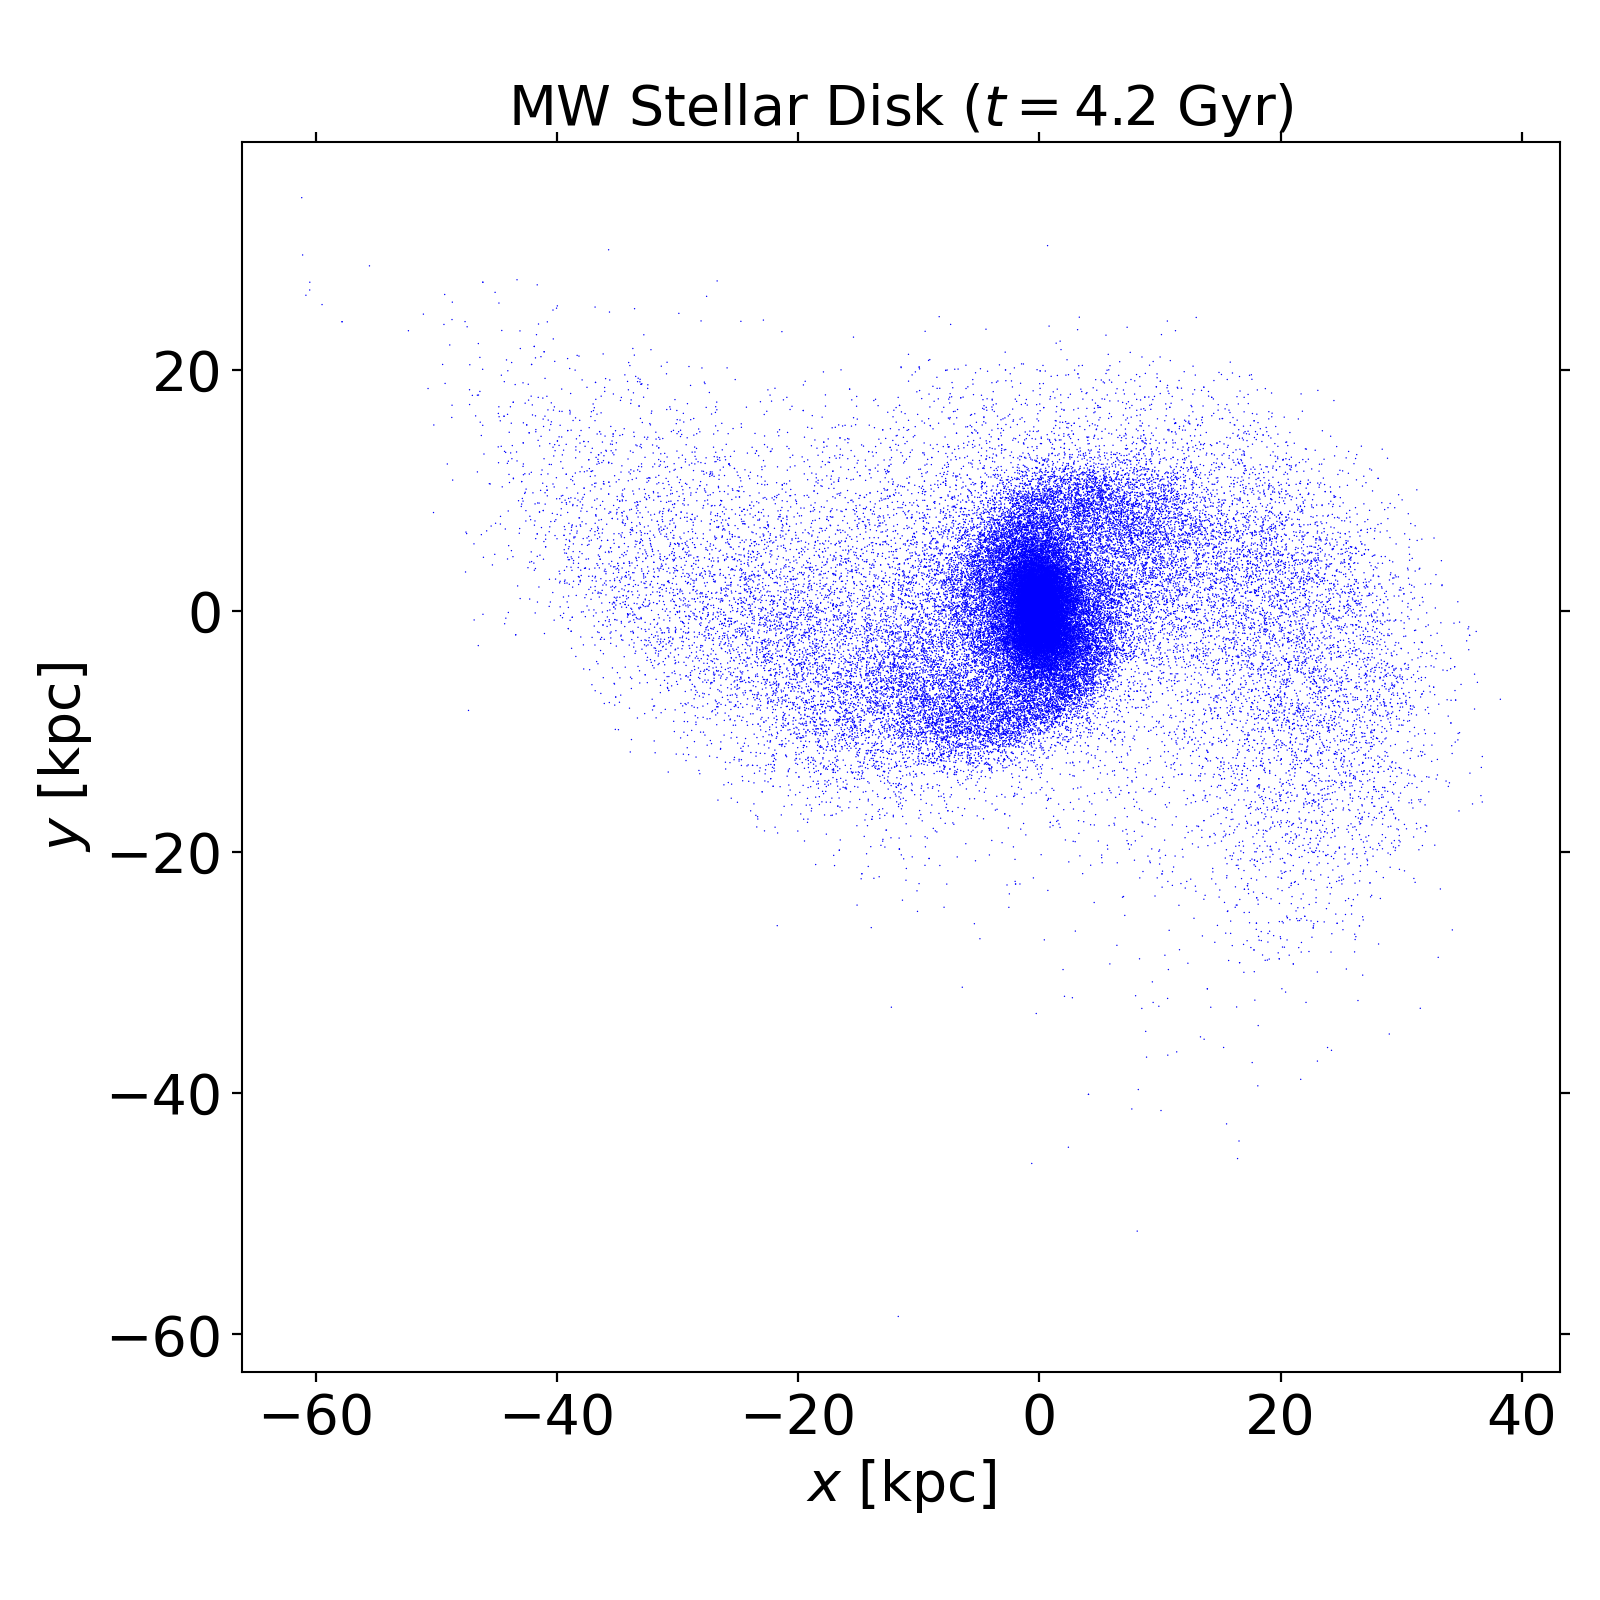

In [56]:
# we can simply plot all particles in a projected view
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sdp1.alg_r[:, 0], sdp1.alg_r[:, 1], ec="None", fc='b', s=0.25)
ax.set(xlabel=r"$x$ [kpc]", ylabel=r"$y$ [kpc]", aspect=1.0,
       title="MW Stellar Disk ($t={:.1f}$ Gyr)".format(sdp1.com.time.value/1e3))
fig.tight_layout()

#### A common way in PPD observations to make spirals more obvious is to plot stuff in the $(r, \theta)$ frame. Below we apply the same method.

<IPython.core.display.Javascript object>


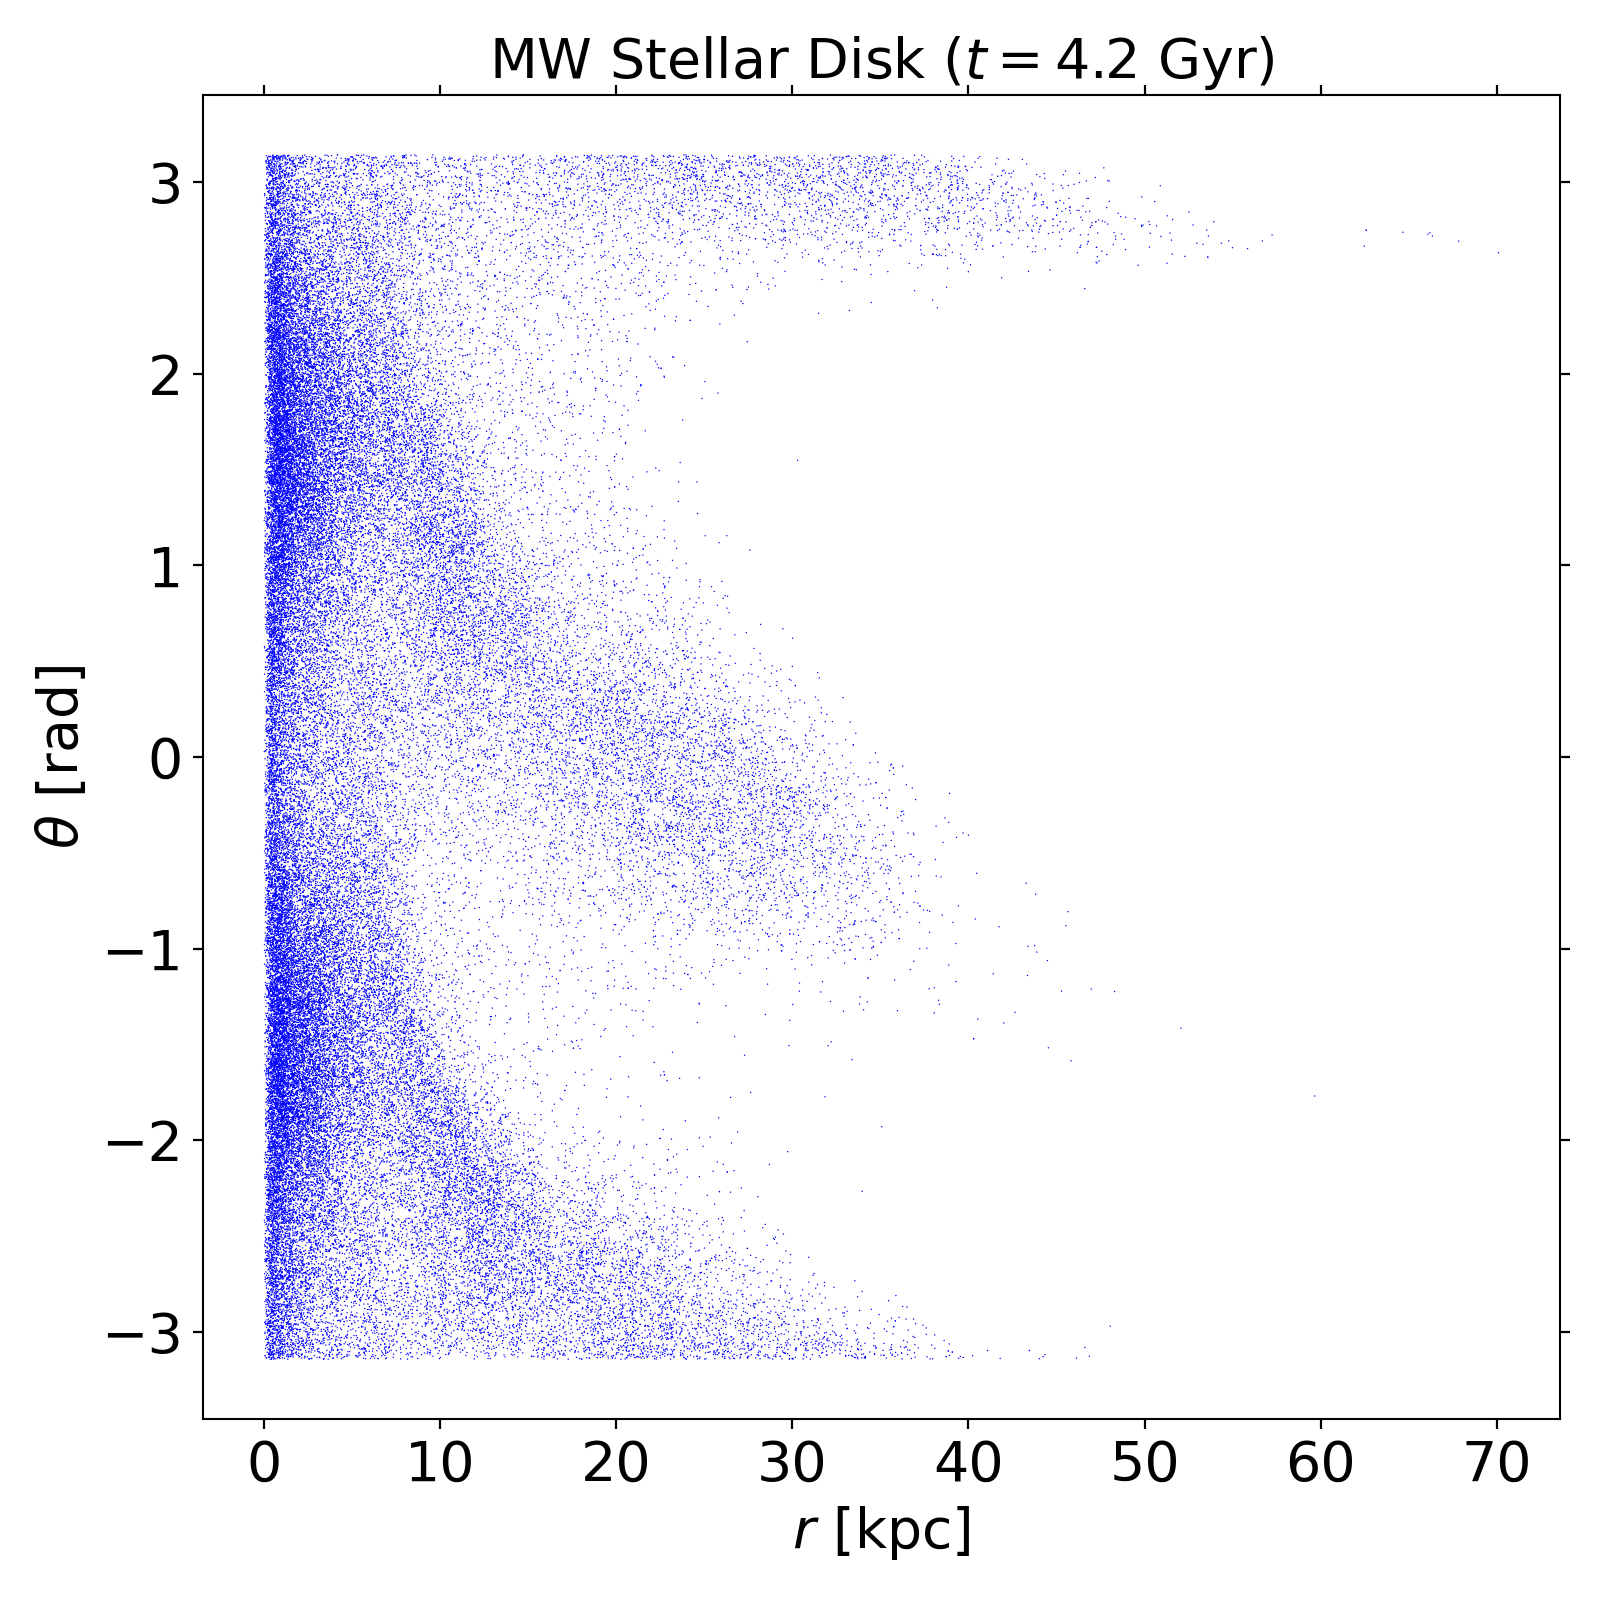

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sdp1.cyl_r_mag, sdp1.cyl_theta, ec="None", fc='b', s=0.25)
ax.set(xlabel=r"$r$ [kpc]", ylabel=r"$\theta$ [rad]",
       title="MW Stellar Disk ($t={:.1f}$ Gyr)".format(sdp1.com.time.value/1e3))
fig.tight_layout()

#### To make the spirals stand out more, we can scale the content (point size in scatter plots, or color in colormaps) with a function of radius. Here, we scale the point size with $\ln(r^2)$. 

#### Combined with the picture below, you may select a desired model to fit the spirals (by overplotting on the figure or performing more calculations) to obtain, for example, the pitch angle.

<IPython.core.display.Javascript object>


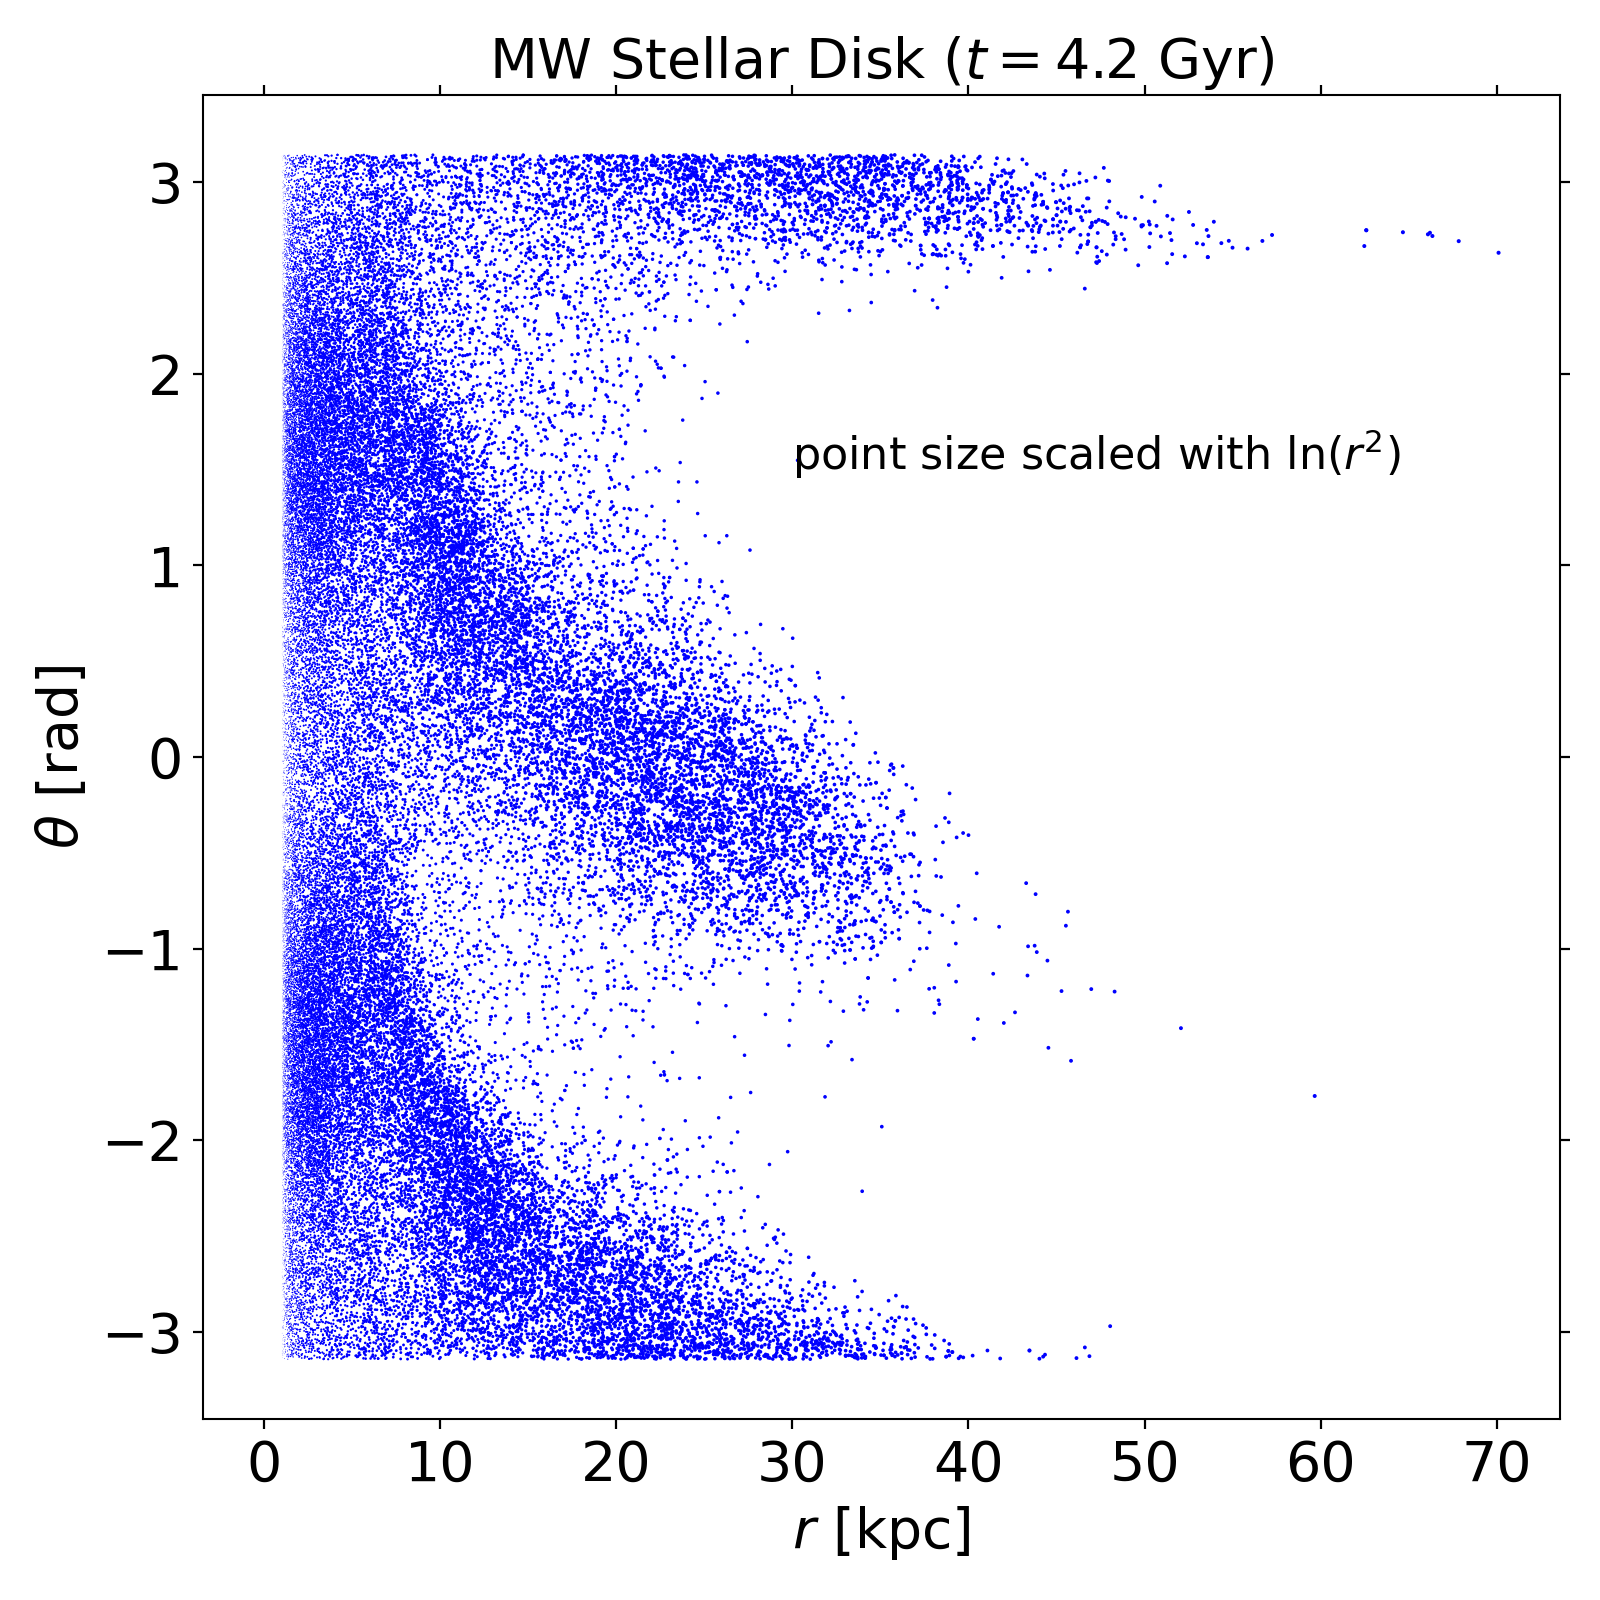

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sdp1.cyl_r_mag, sdp1.cyl_theta, ec="None", fc='b', s=0.25*np.log(sdp1.cyl_r_mag**2))
ax.set(xlabel=r"$r$ [kpc]", ylabel=r"$\theta$ [rad]", 
       title="MW Stellar Disk ($t={:.1f}$ Gyr)".format(sdp1.com.time.value/1e3))
ax.text(30, 1.5, 'point size scaled with $\ln(r^2)$', fontsize=16)
fig.tight_layout()

## 3D Interactive Visualization with Plotly

#### If you want to visualize disk particles in 3D and see how the stellar disk looks like in different perspectives, the following cell gives you an example.

#### Check out their documentation for more examples: [3D Scatter Plots in Python](https://plotly.com/python/3d-scatter-plots/)

In [63]:
layout = plygo.Layout(width=1024, height=800, autosize=False, showlegend=True, scene=dict(aspectmode='data', 
                      xaxis_title='x/kpc', yaxis_title='y/kpc', zaxis_title='z/kpc',                                                                    
                      camera=dict(up=dict(x=0,y=0,z=1), center=dict(x=0,y=0,z=0), eye=dict(x=-0.75,y=-1.25,z=1.5))))
data = [plygo.Scatter3d(x=sdp1.alg_r[::5, 0], y=sdp1.alg_r[::5, 1], z=sdp1.alg_r[::5, 2], mode='markers',
                        marker=dict(size=1, opacity=0.8, color='blue'), name=r"Sample N_par="+str(sdp1.alg_r[::5].shape[0]))]
fig = plygo.Figure(data=data, layout=layout)

# make it a tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), legend=dict(x=0.05, y=0.95, bordercolor="Black", borderwidth=2))
fig.show(renderer='notebook')

# if you want to save the interactive visualization into a HTML file and share with ohters, uncomment the following line
#fig.write_html("portable_visualization.html")